In [1]:
# Import some useful packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
%matplotlib inline

# Load data

In [2]:
# Mount Google Drive Data 
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [3]:
# initialize data direction from my google drive
data_dir = "/content/gdrive/MyDrive/Intern/Kaggle - Predict Future Sales/"

# Read data from drive
test = pd.read_csv(data_dir + 'test.csv')
sales = pd.read_csv(data_dir + 'sales_train.csv')
shops = pd.read_csv(data_dir + 'shops.csv')
items = pd.read_csv(data_dir + 'items.csv')
item_cats = pd.read_csv(data_dir + 'item_categories.csv')

In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# EDA

In [ ]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
# only 'item_price' and	'item_cnt_day' are statistical meaningful to make a summary
sales[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06
mean,8.908532e+02,1.242641e+00
std,1.729800e+03,2.618834e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


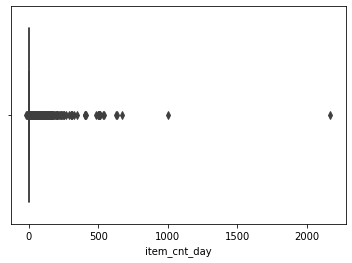

In [ ]:
# visualize the 'item_price' to view outliers
sns.boxplot(x=sales.item_cnt_day)

For the *'item_cnt_day'* column, since most values are 1.00, which means Q1 = Q2 = Q3 and IQR = 0, then directly using range$(Q1-1.5IQR,\ Q3+1.5IQR)$ or range $(abs(z_{score}) \leq 3)$ may not be a good way to remove the outliers. So I will simply remove the points whose value is definately far from other points.

In [ ]:
# from the boxplot, we may find that most of the values lay below 1000
# and only count >= 0 are meaningful
# so make a selection for range (0,1000)
train = sales[(sales.item_cnt_day >= 0) & (sales.item_cnt_day <= 1000)]

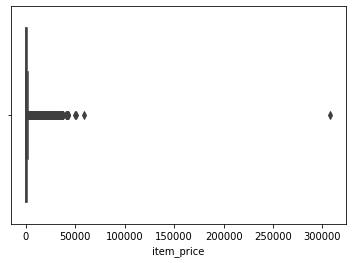

In [ ]:
# visualize the 'item_price' to view outliers
sns.boxplot(x=sales.item_price)

In [ ]:
# similarly as before, I may choose using range(0,10000) for the 'item_price' column
train = train[(sales.item_price < 100000) & (sales.item_price > 0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
# define the identifier varibles 
index_cols = ['shop_id', 'item_id', 'date_block_num']

# define the numerical varibles
num_cols = ['item_price', 'item_cnt_day']

We are actually finding the predicted value for each combination of shop and item in the test set in tuple form of *('shop_id', item_id)*. However, the model may performs really bad if a tuple has not appeared in the test set (ie. a new item in a shop). I may choose to implement data augmentation with Cartesian product, so that more tuples are generated to fit the data distribution in the test set.

In [ ]:
df = [] 

for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


Also, since we are predicting the monthly sales for every tuple *'(shop,item)'*, then we may also need sum up the daily sales to get a monthly sales for the tuples in the training set.

In [ ]:
# Sum up to get month sales
monthly_comb = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
monthly_comb.columns = ['item_cnt_month']
monthly_comb.reset_index(inplace=True)

# merge new column into 'df'
df = pd.merge(df, monthly_comb, on=index_cols, how='left')

# fill empty with 0
df['item_cnt_month'] = df['item_cnt_month'].fillna(0).astype(np.float16)

df.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


Then as the problem descibed, we may set the test set as month 34 and perform the same process on the test set.

In [ ]:
# Process test set

# Add date column
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)

test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)

# fill empty with 0
df.fillna(0,inplace=True)

# Feature Engineering

## Location feature

Add more location information to the dataframe.

In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])


# get the city location information: ('longtitude', 'latitude', 'area code')
# (I get this detailed information on the Kaggle discussion part)
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 


# find correponding infomation for every city
# and add the shop location information to shope table
shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])
shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

# add the new information to data frame
df = pd.merge(df, shops, on=['shop_id'], how='left')

df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2


## Item feature

In [ ]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Now merge the three tables *('item_cats','sales','df')* together.

In [ ]:
# clean th item_category names
map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

# merge items and item_cats
items = pd.merge(items, item_cats, on='item_category_id')

# split by '-' to get the top categories
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]

items.head()

,item_id,item_category_common,item_category_code
0,0,11,40
1,2,11,40
2,3,11,40
3,4,11,40
4,5,11,40


In [ ]:
# merge item and df tables
df = pd.merge(df, items, on=['item_id'], how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,37
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,58
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,58
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,56
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,59


## Time feature

Since in general the sales may be influenced by the number of weekdays and weekends in a months(I guess people are willing to shope more on weekends), also different months may have different days, so we are counting number of weekends and days in a month.

In [ ]:
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

# Operate in the data frame
df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,37,4,31
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,56,4,31
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,59,4,31


## Item selling feature

Since a new-listing item may have some uncommon selling-numbers(ie. people may be more likily to buy new shoes, clothes, etc.). So I wish to find which are the new-listing products and are they sold for the first time.

In [ ]:
# find new listing item, mark 1 as positive
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

# find items are bought brefore or not, mark 1 as positive
first_shop_item_buy_block = df[df['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [ ]:
# merge the item sales information to data frame
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

# fill na 
df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)
 
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 

df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,37,4,31,1,0
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,56,4,31,1,0
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,59,4,31,1,0


## Lag features for the time series

In [ ]:
def lag_feature(df, lags, col):
  # by setting the 'lags' we are able to connect the time line of same tuple together
  tmp = df[['date_block_num','shop_id','item_id',col]]
  for i in lags:
    # copy required data
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]

    # merge current and provious data into same row
    shifted['date_block_num'] += i
    df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    
  return df

First, we slid out the first three months 'sales data for each product in each store for each month:



In [ ]:
#Add sales lags for last 3 months
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')

In [ ]:
#Add avg shop/item price

index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

# compute the average selling price of an item in the current supermarket during the month
df['avg_shop_price'] = (df['avg_shop_price'].fillna(0).astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")

# compute the average price of an item in all shops for the month
df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price'].fillna(0).astype(np.float16))

# compute the percentage difference of current price (item,shop) and average price in all  shops
df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)
df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')

df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,...,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,...,0,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,...,0,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,...,0,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,...,0,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,...,0,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN


According to the result, we find that we actually don't know what's going to happen that month, and that is what we want to predict, so NaN appears in the data frame, then just drop the columns.

In [ ]:
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,...,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,...,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN


# Encoding for the target

In [ ]:
#Add target encoding for items for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc'].fillna(0).astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_target_enc')
df.drop(['item_target_enc'], axis=1, inplace=True)

In [ ]:
#Add target encoding for item/city for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.drop(['item_loc_target_enc'], axis=1, inplace=True)

In [ ]:
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,...,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3
0,59,22154,0,1.0,0.0,30,57.62987,39.87368,2,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,30,57.62987,39.87368,2,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,30,57.62987,39.87368,2,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,30,57.62987,39.87368,2,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,30,57.62987,39.87368,2,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When summarizing the historical information, for the products newly launched in the current month, counting the average sales of other products consistent with the product category in the current month instead.



In [ ]:
#For new items add avg category sales for last 3 months
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)

Since we are always finding the past 3 months information of an item, this method does not work for the new listing items. Inspired by the discussion board, I find that an item has a similar attributes (from the Russian name) with its neighbor rows, so using mean of those historical data instead.



In [ ]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')

Since we are using 3 months as the lag size, the months 0,1,2 may not have such attributes. So drop those data

In [ ]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,...,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv
1122386,25,8092,3,3.0,0.0,13,55.75222,37.61556,1,11,...,1.444336,0.666504,0.666504,2.000000,0.792969,0.618164,0.311279,7.0,5.0,13.0
1122387,25,7850,3,3.0,0.0,13,55.75222,37.61556,1,8,...,3.089844,2.916016,2.083984,2.916016,6.347656,1.189453,1.192383,0.0,0.0,0.0
1122388,25,8051,3,3.0,0.0,13,55.75222,37.61556,1,14,...,0.133301,0.000000,0.333252,0.333252,0.027664,0.036224,0.168701,0.0,0.0,0.0
1122389,25,8088,3,1.0,0.0,13,55.75222,37.61556,1,13,...,0.066650,0.166626,0.083313,0.000000,0.386230,0.108521,0.208374,0.0,1.0,0.0
1122390,25,8089,3,1.0,0.0,13,55.75222,37.61556,1,13,...,0.177734,0.666504,0.250000,0.083313,0.386230,0.108521,0.208374,2.0,0.0,3.0


In [ ]:
# Save the pre-processed data
df.drop(['ID'], axis=1, inplace=True, errors='ignore')
df.to_pickle('df.pkl')

# Modeling

In [ ]:
# load pre-processed data
df = pd.read_pickle(data_dir + 'df.pkl')
df.info()

# use first 32 months as training set 
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']

# use month 33 as validation 
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']

# months 34 is the target month
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976322 entries, 1122386 to 11098707
Data columns (total 32 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int32  
 1   item_id                    int32  
 2   date_block_num             int32  
 3   item_cnt_month             float16
 4   city_code                  int64  
 5   city_coord_1               float64
 6   city_coord_2               float64
 7   country_part               int64  
 8   item_category_common       int64  
 9   item_category_code         int64  
 10  weeknd_count               int64  
 11  days_in_month              int64  
 12  item_first_interaction     int8   
 13  shop_item_sold_before      int8   
 14  item_cnt_month_lag_1       float16
 15  item_cnt_month_lag_2       float16
 16  item_cnt_month_lag_3       float16
 17  item_shop_price_avg_lag_1  float16
 18  item_shop_price_avg_lag_2  float16
 19  item_shop_price_avg_lag_3  float16


# Train with *LightGBM*

For the model selection:
I am thinking to try some classic machine learning models first, cause usaully nueral network models cost more time and resources to train, and we only need to predict data for one month. In general, boosting algorithms usually have a better performance than other methods. Here I choose to train with LightGBM, which is a framework for implementing GBDT algorithm, which supports efficient parallel training and has the following advantages:

Faster training speed

Lower memory consumption

Better accuracy, aviod overfitting issue

Distributed support, can quickly process massive data

In [ ]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 3.4543	valid_1's rmse: 2.6638
[10]	training's rmse: 3.40809	valid_1's rmse: 2.62848
[15]	training's rmse: 3.36315	valid_1's rmse: 2.60274
[20]	training's rmse: 3.31854	valid_1's rmse: 2.57471
[25]	training's rmse: 3.27605	valid_1's rmse: 2.54926
[30]	training's rmse: 3.23545	valid_1's rmse: 2.52522
[35]	training's rmse: 3.19401	valid_1's rmse: 2.49955
[40]	training's rmse: 3.15518	valid_1's rmse: 2.47374
[45]	training's rmse: 3.11694	valid_1's rmse: 2.44998
[50]	training's rmse: 3.08023	valid_1's rmse: 2.42341
[55]	training's rmse: 3.04471	valid_1's rmse: 2.40119
[60]	training's rmse: 3.0105	valid_1's rmse: 2.38068
[65]	training's rmse: 2.97814	valid_1's rmse: 2.35832
[70]	training's rmse: 2.94578	valid_1's rmse: 2.33846
[75]	training's rmse: 2.91433	valid_1's rmse: 2.32178
[80]	training's rmse: 2.88358	valid_1's rmse: 2.29883
[85]	training's rmse: 2.85546	valid_1's rmse: 2.2811
[90]	training's rmse: 2.

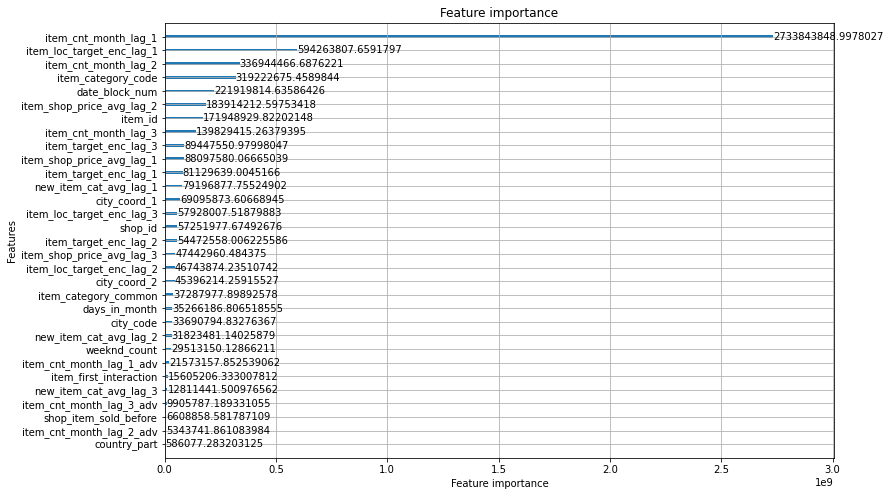

In [ ]:
# plot the importance of features
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

According to the importance table *'item_cnt_mth_lag1'* explained much more inportance than others, this also make sence. Cause the sales of an item in current months are basically predicted by using  the data in previous months.

# Try LSTM

**########## Really sorry due to some other due from my school work, I may not able to compelte this part #########**

In [ ]:
import time

from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(1)

# Enable CUDA
gpu_boole = torch.cuda.is_available()
print('CUDA is enabled:', gpu_boole)

CUDA is enabled: True


In [ ]:
# Mount Google Drive Data 
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
# initialize data direction from my google drive
data_dir = "/content/gdrive/MyDrive/Intern/Kaggle - Predict Future Sales/"

# Read data from drive
test = pd.read_csv(data_dir + 'test.csv')
sales = pd.read_csv(data_dir + 'sales_train.csv')
shops = pd.read_csv(data_dir + 'shops.csv')
items = pd.read_csv(data_dir + 'items.csv')
item_cats = pd.read_csv(data_dir + 'item_categories.csv')

In [ ]:
# load pre-processed data
df = pd.read_pickle('df.pkl')
df.info()

# use first 32 months as training set 
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']

# use month 33 as validation 
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']

# months 34 is the target month
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976322 entries, 1122386 to 11098707
Data columns (total 32 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int32  
 1   item_id                    int32  
 2   date_block_num             int32  
 3   item_cnt_month             float16
 4   city_code                  int64  
 5   city_coord_1               float64
 6   city_coord_2               float64
 7   country_part               int64  
 8   item_category_common       int64  
 9   item_category_code         int64  
 10  weeknd_count               int64  
 11  days_in_month              int64  
 12  item_first_interaction     int8   
 13  shop_item_sold_before      int8   
 14  item_cnt_month_lag_1       float16
 15  item_cnt_month_lag_2       float16
 16  item_cnt_month_lag_3       float16
 17  item_shop_price_avg_lag_1  float16
 18  item_shop_price_avg_lag_2  float16
 19  item_shop_price_avg_lag_3  float16


In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 3
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
# convert data into tensor to feed into lstm
X_train = Variable(torch.Tensor(np.array(X_train)))
Y_train = Variable(torch.Tensor(np.array(Y_train)))

X_valid = Variable(torch.Tensor(np.array(X_valid)))
Y_valid = Variable(torch.Tensor(np.array(Y_valid)))

X_test = Variable(torch.Tensor(np.array(X_test)))

In [ ]:
num_epochs = 200
learning_rate = 0.01

input_size = 32
hidden_size = 100
num_layers = 1

num_classes = 1 

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

if gpu_boole:
  lstm = lstm.cuda()

if gpu_boole:
  X_train = X_train.cuda()
  Y_train = Y_train.cuda()


criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):

  lstm.train()

  outputs = lstm(X_train)
  optimizer.zero_grad()
    
  # obtain the loss function
  loss = criterion(outputs, Y_train)
    
  loss.backward()
    
  optimizer.step()
  print("Epoch: %d, train loss: %1.5f" % (epoch, loss.item()))

  # begin validation part 
  lstm.eval()
  val_outputs = lstm(X_valid)
  val_loss = criterion(val_outputs, Y_valid)
  print("Epoch: %d, valid loss: %1.5f" % (epoch, val_loss.item()))

In [ ]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)